## Classification automatique (Clustering) sur les eaux


**Description des données**  
On dispose d’un fichier comprenant les variables explicitées ci-dessous pour étudier 57 marques d’eaux en bouteille:  

**NOM** : le nom complet de l’eau inscrit sur l’étiquette.  
**PAYS** : le pays d’origine identifié par les lettres de l’immatriculation automobile officielle.  
**TYPE** : à deux modalités : M    pour  eau minérale ,     S    pour eau de source.  
**PG** : à deux modalités : P   pour eau plate,    G    pour eau gazeuse.  
**CA** : ions calcium en mg/litre.  
**MG** : ions magnésium en mg/litre.  
**NA** : ions sodium en mg/litre.  
**K** : ions potassium en mg/litre.  
**SUL** : ions sulfates en mg/litre.  
**NO3** : ions nitrates en mg/litre.  
**HCO3** : ions carbonates en mg/litre.  
**CL** : ions chlorures en mg/litre.  

##### RUBRIQUES

1. [IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES](#import_check)  

2. [ANALYSE EXPLORATOIRE](#analyse_exploratoire)  

3. [CAH](#cah)

[REQUIREMENTS.txt](#requirements)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

---

## <a id="import_check" style="color:black">1. IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES</a>

In [2]:
df = pd.read_table("../data/csv-txt/eaux/donnees_eaux.txt", encoding="iso-8859-1")

In [3]:
df.head()

,NOM,ACRO,PAYS,TYPE,PG,CA,MG,NA,K,SUL,NO3,HCO3,CL
0,Evian,EVIAN,F,M,P,78,24,5,1,10,"3,8",357,"4,5"
1,Montagne des Pyrénées,MTPYR,F,S,P,48,11,34,1,16,4,183,50
2,Cristaline-St-Cyr,CRIST,F,S,P,71,"5,5","11,2","3,2",5,1,250,20
3,Fiée des Lois,FIEE,F,S,P,89,31,17,2,47,0,360,28
4,Volcania,VOLCA,F,S,P,"4,1","1,7","2,7","0,9","1,1","0,8","25,8","0,9"


In [4]:
df.columns = ["nom","acronyme","pays","type","pg","ca","mg","na","k","sul","no3","hco3","cl"]

In [5]:
df.head()

,nom,acronyme,pays,type,pg,ca,mg,na,k,sul,no3,hco3,cl
0,Evian,EVIAN,F,M,P,78,24,5,1,10,"3,8",357,"4,5"
1,Montagne des Pyrénées,MTPYR,F,S,P,48,11,34,1,16,4,183,50
2,Cristaline-St-Cyr,CRIST,F,S,P,71,"5,5","11,2","3,2",5,1,250,20
3,Fiée des Lois,FIEE,F,S,P,89,31,17,2,47,0,360,28
4,Volcania,VOLCA,F,S,P,"4,1","1,7","2,7","0,9","1,1","0,8","25,8","0,9"


In [6]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nom       57 non-null     object
 1   acronyme  57 non-null     object
 2   pays      57 non-null     object
 3   type      57 non-null     object
 4   pg        57 non-null     object
 5   ca        57 non-null     object
 6   mg        57 non-null     object
 7   na        57 non-null     object
 8   k         57 non-null     object
 9   sul       57 non-null     object
 10  no3       57 non-null     object
 11  hco3      57 non-null     object
 12  cl        57 non-null     object
dtypes: object(13)
memory usage: 43.8 KB


In [7]:
df.iloc[:,5:] = df.iloc[:,5:].replace(",", ".", regex=True)

In [8]:
df.dtypes

nom         object
acronyme    object
pays        object
type        object
pg          object
ca          object
mg          object
na          object
k           object
sul         object
no3         object
hco3        object
cl          object
dtype: object

In [9]:
for i in df.columns[5:]:
    df[i] = pd.to_numeric(df[i])

In [10]:
df.dtypes

nom          object
acronyme     object
pays         object
type         object
pg           object
ca          float64
mg          float64
na          float64
k           float64
sul         float64
no3         float64
hco3        float64
cl          float64
dtype: object

In [11]:
df.isnull().sum()

nom         0
acronyme    0
pays        0
type        0
pg          0
ca          0
mg          0
na          0
k           0
sul         0
no3         0
hco3        0
cl          0
dtype: int64

In [12]:
# Pour détecter les chaînes vides
df.apply(lambda x: x == "", axis=1).sum()

nom         0
acronyme    0
pays        0
type        0
pg          0
ca          0
mg          0
na          0
k           0
sul         0
no3         0
hco3        0
cl          0
dtype: int64

In [14]:
df.select_dtypes(include=["object"]).describe()

,nom,acronyme,pays,type,pg
count,57,57,57,57,57
unique,57,56,6,2,2
top,Evian,VERN,F,M,P
freq,1,2,40,38,41


In [15]:
df[df.duplicated(subset=["acronyme"], keep=False)]

,nom,acronyme,pays,type,pg,ca,mg,na,k,sul,no3,hco3,cl
42,Vernière,VERN,F,M,G,190.0,72.0,154.0,49.0,158.0,0.0,1170.0,18.0
53,Vernet,VERN,F,M,G,33.5,17.6,192.0,28.7,14.0,1.0,734.0,6.4


In [16]:
df.loc[df.nom == "Vernière", "acronyme"] = "VERNI"

In [17]:
# check
df.loc[df.nom == "Vernière", "acronyme"]

42    VERNI
Name: acronyme, dtype: object

## <a id="analyse_exploratoire" style="color:black">2. ANALYSE EXPLORATOIRE</a>

Se référer au notebook 'acp eaux' pour l'analyse exploratoire détaillée

## <a id="cah" style="color:black">3. CAH</a>

In [18]:
## Standardiser
sc = StandardScaler()

arr = sc.fit_transform(df.iloc[:,5:])

In [19]:
mat_liens = linkage(arr, method="ward", metric="euclidean")

In [20]:
mat_liens.shape

(56, 4)

In [21]:
mat_liens

array([[1.20000000e+01, 3.10000000e+01, 0.00000000e+00, 2.00000000e+00],
       [8.00000000e+00, 1.10000000e+01, 0.00000000e+00, 2.00000000e+00],
       [3.40000000e+01, 4.60000000e+01, 4.11050088e-02, 2.00000000e+00],
       [1.00000000e+00, 3.90000000e+01, 4.49568182e-02, 2.00000000e+00],
       [4.00000000e+00, 4.80000000e+01, 6.34859104e-02, 2.00000000e+00],
       [4.50000000e+01, 6.00000000e+01, 1.06521756e-01, 3.00000000e+00],
       [6.00000000e+00, 2.70000000e+01, 1.10691295e-01, 2.00000000e+00],
       [2.40000000e+01, 3.80000000e+01, 1.46361520e-01, 2.00000000e+00],
       [2.30000000e+01, 2.80000000e+01, 1.74948590e-01, 2.00000000e+00],
       [2.10000000e+01, 2.50000000e+01, 1.78726563e-01, 2.00000000e+00],
       [3.30000000e+01, 5.50000000e+01, 2.05313381e-01, 2.00000000e+00],
       [2.00000000e+01, 4.00000000e+01, 2.24152228e-01, 2.00000000e+00],
       [2.90000000e+01, 5.60000000e+01, 2.39286126e-01, 2.00000000e+00],
       [3.50000000e+01, 6.10000000e+01, 2.65252922e

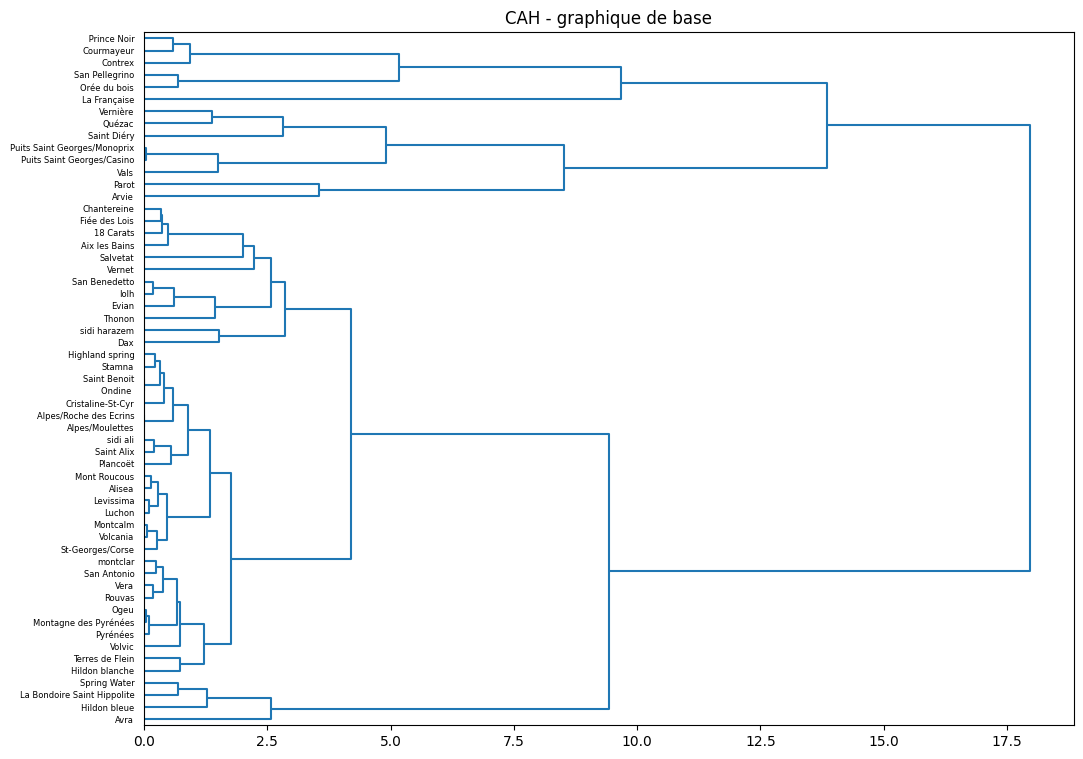

In [22]:
plt.figure(figsize=(12,9))

plt.title("CAH - graphique de base")
dendrogram(mat_liens, labels=df.nom.to_numpy(), orientation="right", color_threshold=0)
plt.show()

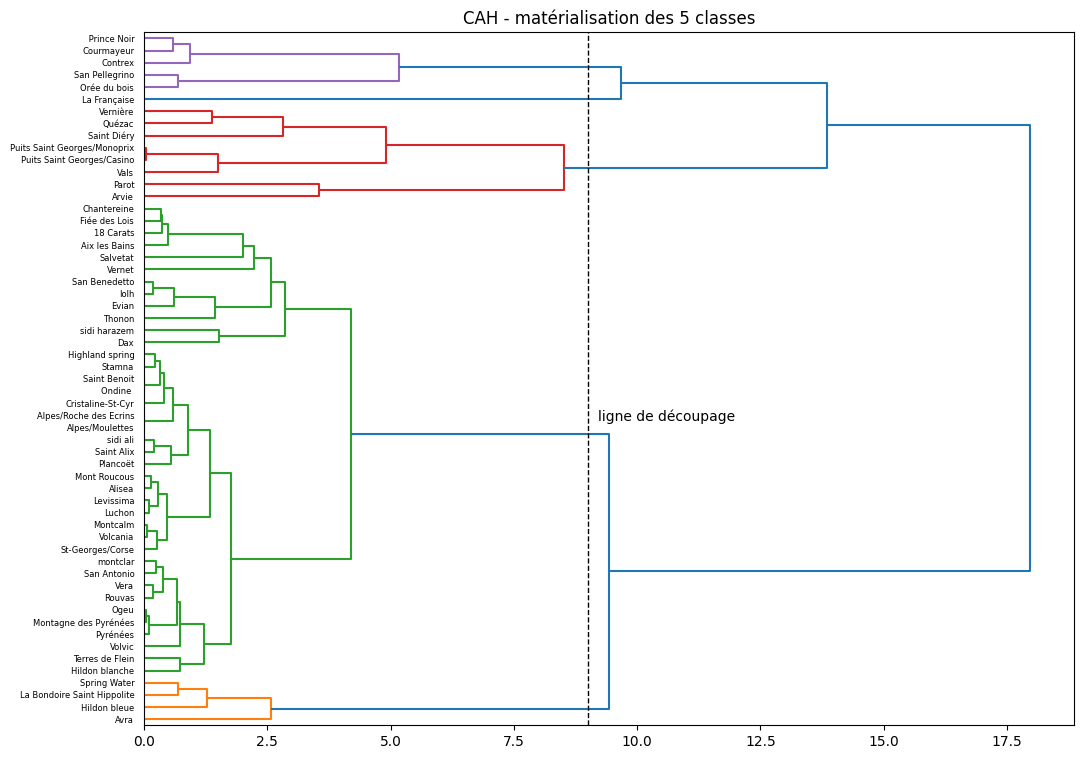

In [23]:
## choix du seuil de découpage des classes

plt.figure(figsize=(12,9))

plt.title("CAH - matérialisation des 5 classes")
dendrogram(mat_liens, labels=df.nom.to_numpy(), orientation="right", color_threshold=9)
plt.axvline(9, color='black', linestyle='dashed', linewidth=1)
plt.annotate("ligne de découpage", xy=(9, 4.5), xytext=(9.2, 250))
plt.show()

In [24]:
## Extraction des groupes

groupes = fcluster(mat_liens, t=9, criterion="distance")
groupes

array([2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 3, 2, 2, 2, 2, 4, 1, 2, 3, 2, 2, 2,
       1, 2, 2, 2, 4, 2, 2, 2, 5, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 3, 3, 2,
       4, 2, 3, 4, 2, 2, 2, 1, 3, 2, 2, 2, 2], dtype=int32)

In [25]:
# Tri des indices des groupes
idx = np.argsort(groupes)
idx

array([51, 16, 36, 22,  0, 27, 55, 29, 31, 32, 33, 35, 38, 39, 40, 43, 45,
       48, 49, 50, 53, 54, 37, 25, 28, 23,  1,  2,  3,  4,  6,  7,  8, 24,
       11, 12, 56, 14, 21, 20, 19, 17, 13, 52,  5, 46, 42, 41, 10, 34, 18,
       44, 47, 15, 26,  9, 30], dtype=int64)

In [26]:
pd.DataFrame({"Eau":df.nom[idx], "Groupe":groupes[idx]})

,Eau,Groupe
51,Spring Water,1
16,La Bondoire Saint Hippolite,1
36,Hildon bleue,1
22,Avra,1
0,Evian,2
27,Levissima,2
55,sidi ali,2
29,San Antonio,2
31,Saint Benoit,2
32,Plancoët,2


In [27]:
## Interprétation des classes (univariée)

#moyenne par variable
m = df.mean()

print("Moyennes par variables \n")
print(m)
print("\n===========================================\n")

#TSS
TSS = df.shape[0]*df.var(ddof=0)
print(TSS)


Moyennes par variables 

ca      102.458246
mg       25.861930
na       93.851754
k        11.090351
sul     135.661404
no3       3.834211
hco3    442.166842
cl       52.473684
dtype: float64


ca      8.060394e+05
mg      4.484471e+04
na      2.178853e+06
k       3.343664e+04
sul     6.069173e+06
no3     2.490926e+03
hco3    2.072161e+07
cl      1.149148e+06
dtype: float64


C:\Users\Nelly\AppData\Local\Temp\ipykernel_14132\945041153.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m = df.mean()
C:\Users\Nelly\AppData\Local\Temp\ipykernel_14132\945041153.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  TSS = df.shape[0]*df.var(ddof=0)


In [28]:
#dataframe conditionnellement aux clusters
gb_cah = df.groupby(groupes)

#effectifs conditionnels aux clusters
nk_cah= gb_cah.size()

#moyennes conditionnelles aux clusters
mk_cah= gb_cah.mean()

print("Moyennes conditionnelles aux clusters \n")
print(mk_cah)
print("\n===========================================\n")

#pour chaque cluster, écart à la moyenne par variable
EMk_cah= (mk_cah - m)**2

#pondéré par les effectifs du groupe
EM_cah = EMk_cah.multiply(nk_cah,axis=0)

#somme des valeurs => BSS
BSS_cah = np.sum(EM_cah,axis=0)

#carré du rapport de corrélation
eta2_cah = BSS_cah/TSS

print("Part de la variance totale expliquée par l'appartenance aux clusters \n")
print(eta2_cah.sort_values(ascending=False))

Moyennes conditionnelles aux clusters 

           ca         mg          na          k          sul        no3  \
1  102.700000   8.400000   11.525000   1.175000    16.675000  25.250000   
2   55.900513  12.493077   20.916667   3.052564    28.023077   2.320513   
3  115.275000  64.425000  466.125000  58.312500    54.237500   2.612500   
4  394.600000  70.980000   21.140000   3.980000  1016.840000   1.230000   
5  354.000000  83.000000  653.000000  22.000000  1055.000000   0.000000   

          hco3          cl  
1   301.450000   18.250000  
2   216.184615   22.048718  
3  1741.238750  115.150000  
4   282.320000   30.980000  
5   225.000000  982.000000  


Part de la variance totale expliquée par l'appartenance aux clusters 

sul     0.871467
cl      0.816729
no3     0.796674
na      0.772128
hco3    0.759906
mg      0.747688
ca      0.714430
k       0.631767
dtype: float64


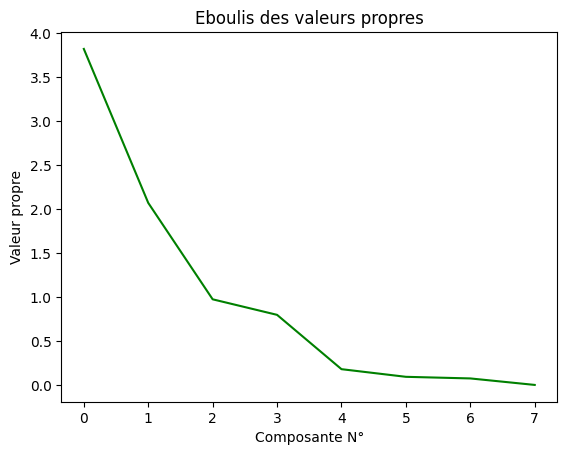

In [29]:
## Interprétation des classes (multivarié): pour tenir compte des liaisons entre les variables
## Ici, le cluster est considéré comme une variable illustrative (quali)

acp = PCA(svd_solver="full")
coords = acp.fit_transform(arr)
val_propres = (acp.singular_values_**2/df.shape[0])

plt.plot(np.arange(0, df.iloc[:,5:].shape[1]), val_propres, "g-")
plt.title("Eboulis des valeurs propres")
plt.xlabel("Composante N°")
plt.ylabel("Valeur propre")
plt.show()

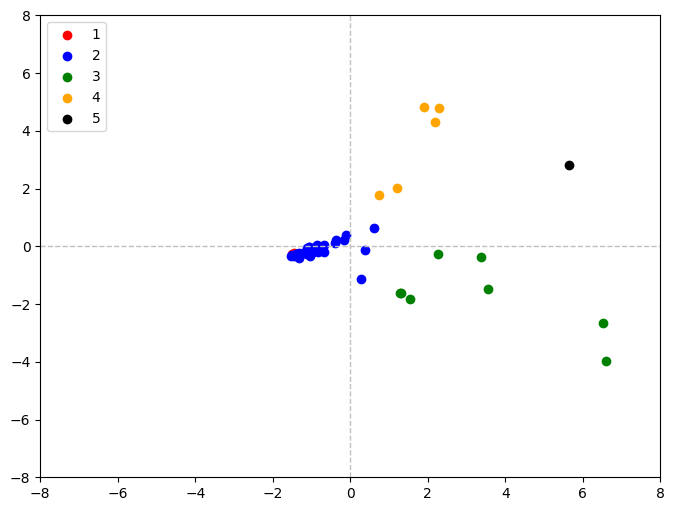

In [30]:
## Affichage des clusters dans le 1er plan factoriel

plt.figure(figsize=(8,6))

for couleur, k in zip(["red","blue","green","orange","black"], np.unique(groupes)):
    plt.scatter(coords[groupes== k , 0], coords[groupes == k, 1], c=couleur, label=k)


plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.legend(loc=2)
plt.axvline(0, color="silver", linestyle="dashed", linewidth=1)
plt.axhline(0, color="silver", linestyle="dashed", linewidth=1)
plt.show()

## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.8</span>

Requirements.txt  

```
absl-py==2.1.0
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0       
arrow==1.2.3
asttokens==2.4.0
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==4.2.4
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==2.0.12
colorama==0.4.6
comm==0.1.4
cycler==0.11.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.1.3
executing==1.2.0
fastjsonschema==2.18.0
fonttools==4.42.1
fqdn==1.5.1
gast==0.3.3
google-auth==1.35.0
google-auth-oauthlib==0.4.6        
google-pasta==0.2.0
grpcio==1.66.2
h5py==2.10.0
htmlmin==0.1.12
idna==3.4
ImageHash==4.3.1
importlib-metadata==8.5.0
importlib-resources==6.4.5
ipykernel==6.25.2
ipython==8.12.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.0
Jinja2==3.1.2
joblib==1.1.1
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.0
jsonschema-specifications==2023.7.1
jupyter==1.0.0
jupyter-client==8.3.1
jupyter-console==6.6.3
jupyter-core==5.3.1
jupyter-events==0.7.0
jupyter-lsp==2.2.0
jupyter-server==2.7.3
jupyter-server-terminals==0.4.4
jupyterlab==4.0.6
jupyterlab-pygments==0.2.2
jupyterlab-server==2.25.0
jupyterlab-widgets==3.0.9
Keras==2.4.3
Keras-Preprocessing==1.1.2
kiwisolver==1.4.5
Markdown==3.7
MarkupSafe==2.1.3
matplotlib==3.5.3
matplotlib-inline==0.1.6
missingno==0.5.2
mistune==3.0.1
multimethod==1.8
nbclient==0.8.0
nbconvert==7.8.0
nbformat==5.9.2
nest-asyncio==1.5.8
networkx==3.1
notebook==7.0.3
notebook-shim==0.2.3
numpy==1.22.0
oauthlib==3.2.2
opt-einsum==3.4.0
overrides==7.4.0
packaging==23.1
pandas==1.4.0
pandas-profiling==3.3.0
pandocfilters==1.5.0
parso==0.8.3
patsy==0.5.3
pexpect==4.8.0
phik==0.12.3
pickleshare==0.7.5
Pillow==10.0.1
pkgutil-resolve-name==1.3.10
platformdirs==3.10.0
prometheus-client==0.17.1
prompt-toolkit==3.0.39
protobuf==3.20.3
psutil==5.9.5
ptyprocess==0.7.0
pure-eval==0.2.2
pyasn1==0.6.1
pyasn1-modules==0.4.1
pycparser==2.21
pydantic==1.9.2
Pygments==2.16.1
pyparsing==3.1.1
python-dateutil==2.8.2
python-json-logger==2.0.7
pytz==2023.3.post1
PyWavelets==1.4.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==25.1.1
qtconsole==5.4.4
QtPy==2.4.0
referencing==0.30.2
requests==2.28.0
requests-oauthlib==2.0.0
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.10.3
rsa==4.9
scikit-learn==0.23.2
scipy==1.4.1
seaborn==0.11.2
Send2Trash==1.8.2
six==1.16.0
sniffio==1.3.0
soupsieve==2.5
stack-data==0.6.2
statsmodels==0.13.5
tangled-up-in-unicode==0.2.0
tensorboard==2.2.2
tensorboard-plugin-wit==1.8.1
tensorflow==2.2.0
tensorflow-estimator==2.2.0
termcolor==2.4.0
terminado==0.17.1
threadpoolctl==3.5.0
tinycss2==1.2.1
tomli==2.0.1
tornado==6.3.3
tqdm==4.64.1
traitlets==5.10.0
typing-extensions==4.7.1
uri-template==1.3.0
urllib3==1.26.16
visions==0.7.5
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.6.3
werkzeug==3.0.4
widgetsnbextension==4.0.9
wrapt==1.16.0
xlrd==2.0.1
zipp==3.20.2
```